This kernel is not going to be a high scoring one but, hopefully, will clarify some aspects of categorical variables that can be confusing when approached for the first time.

We will make experiments together and observe the results. We are going to use only a few categorical features to keep it simple, thus compromising the score since we are not going to use the most relevant features. 

To do so, we are going to use various approaches and see how 3 different models (ordinary least squares, lasso regression, and decision tree) behave.

The main topics we are going to explore are:

* Categorical vs ordinal features
* Dummies and Dummy mismatch
* Multicollinearity
* Creating categories out of continuous variables
* Dealing with numerous categories and frequency encoders

***Note***: As everything on the internet, you should not believe to everything you read but, in the spirit of this notebook, it is an excellent idea to run more experiments to prove me wrong. (And please let the feedback coming)

# Data preparation

Following [this other kernel of mine](https://www.kaggle.com/lucabasa/an-agile-approach-get-incrementally-better), we can quickly prepare the data by handling missing values and selecting the features we want to focus on. As the linked kernel shows, this is the step that gives the biggest improvement in score (both in cross-validation and on the public LB). However, we won't focus on this step too much since it is not the topic of this kernel.

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import statsmodels.formula.api as sm
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor


import warnings

# seaborn and scipy versions are not aligned in the docker image
warnings.filterwarnings("ignore", message="Using a non-tuple sequence for multidimensional indexing is deprecated")

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

df_train = df_train[df_train.GrLivArea < 4500].copy()  # the documentation says they are outliers

combine = [df_train, df_test]
df_train.name = 'Train'
df_test.name = 'Test'

for df in combine:
    # LotFrontage
    df.loc[df.LotFrontage.isnull(), 'LotFrontage'] = 0
    # Alley
    df.loc[df.Alley.isnull(), 'Alley'] = "NoAlley"
    # MSSubClass
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    # MissingBasement
    fil = ((df.BsmtQual.isnull()) & (df.BsmtCond.isnull()) & (df.BsmtExposure.isnull()) &
          (df.BsmtFinType1.isnull()) & (df.BsmtFinType2.isnull()))
    fil1 = ((df.BsmtQual.notnull()) | (df.BsmtCond.notnull()) | (df.BsmtExposure.notnull()) |
          (df.BsmtFinType1.notnull()) | (df.BsmtFinType2.notnull()))
    df.loc[fil1, 'MisBsm'] = 0
    df.loc[fil, 'MisBsm'] = 1
    # BsmtQual
    df.loc[fil, 'BsmtQual'] = "NoBsmt" # missing basement
    # BsmtCond
    df.loc[fil, 'BsmtCond'] = "NoBsmt" # missing basement
    # BsmtExposure
    df.loc[fil, 'BsmtExposure'] = "NoBsmt" # missing basement
    # BsmtFinType1
    df.loc[fil, 'BsmtFinType1'] = "NoBsmt" # missing basement
    # BsmtFinType2
    df.loc[fil, 'BsmtFinType2'] = "NoBsmt" # missing basement
    # FireplaceQu
    df.loc[(df.Fireplaces == 0) & (df.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" # missing
    # MisGarage
    fil = ((df.GarageYrBlt.isnull()) & (df.GarageType.isnull()) & (df.GarageFinish.isnull()) &
          (df.GarageQual.isnull()) & (df.GarageCond.isnull()))
    fil1 = ((df.GarageYrBlt.notnull()) | (df.GarageType.notnull()) | (df.GarageFinish.notnull()) |
          (df.GarageQual.notnull()) | (df.GarageCond.notnull()))
    df.loc[fil1, 'MisGarage'] = 0
    df.loc[fil, 'MisGarage'] = 1
    # GarageYrBlt
    df.loc[df.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007  # correct mistake
    df.loc[fil, 'GarageYrBlt'] = 0
    # GarageType
    df.loc[fil, 'GarageType'] = "NoGrg" # missing garage
    # GarageFinish
    df.loc[fil, 'GarageFinish'] = "NoGrg" # missing
    # GarageQual
    df.loc[fil, 'GarageQual'] = "NoGrg" # missing
    # GarageCond
    df.loc[fil, 'GarageCond'] = "NoGrg" # missing
    # Fence
    df.loc[df.Fence.isnull(), 'Fence'] = "NoFence" # missing fence
    # Dropping stuff
    del df['PoolQC']
    del df['MiscFeature']

# Fixing some entries in test
df_test[['BsmtUnfSF', 
         'TotalBsmtSF', 
         'BsmtFinSF1', 
         'BsmtFinSF2']] = df_test[['BsmtUnfSF', 
                                   'TotalBsmtSF', 
                                   'BsmtFinSF1', 
                                   'BsmtFinSF2']].fillna(0) # checked

# eliminating entries in train with missing values
for f in df_train.columns:
    df_train = df_train[pd.notnull(df_train[f])]
    
    
df_train['target'] = np.log1p(df_train.SalePrice)

In [3]:
#To find the segment of the missing values, can be useful to impute the missing values
def find_segment(df, feat): 
    mis = df[feat].isnull().sum()
    cols = df.columns
    seg = []
    for col in cols:
        vc = df[df[feat].isnull()][col].value_counts(dropna=False).iloc[0]
        if (vc == mis): #returns the columns for which the missing entries have only 1 possible value
            seg.append(col)
    return seg

# to find the mode of the missing feature, by choosing the right segment to compare (uses find_segment)
def find_mode(df, feat): #returns the mode to fill in the missing feat
    md = df[df[feat].isnull()][find_segment(df, feat)].dropna(axis=1).mode()
    md = pd.merge(df, md, how='inner')[feat].mode().iloc[0]
    return md

# identical to the previous one, but with the median
def find_median(df, feat): #returns the median to fill in the missing feat
    md = df[df[feat].isnull()][find_segment(df, feat)].dropna(axis=1).mode()
    md = pd.merge(df, md, how='inner')[feat].median()
    return md

# find the mode in a segment defined by the user
def similar_mode(df, col, feats): #returns the mode in a segment made by similarity in feats
    sm = df[df[col].isnull()][feats]
    md = pd.merge(df, sm, how='inner')[col].mode().iloc[0]
    return md

# Find the median in a segment defined by the user
def similar_median(df, col, feats): #returns the median in a segment made by similarity in feats
    sm = df[df[col].isnull()][feats]
    md = pd.merge(df, sm, how='inner')[col].median()
    return md

In [4]:
# Cleaning of test 

# MSZoning
md = find_mode(df_test, 'MSZoning')
print("MSZoning {}".format(md))
df_test[['MSZoning']] = df_test[['MSZoning']].fillna(md)
# Utilities
md = 'AllPub'
df_test[['Utilities']] = df_test[['Utilities']].fillna(md)
# MasVnrType
md = find_mode(df_test, 'MasVnrType')
print("MasVnrType {}".format(md))
df_test[['MasVnrType']] = df_test[['MasVnrType']].fillna(md)
# MasVnrArea
md = find_mode(df_test, 'MasVnrArea')
print("MasVnrArea {}".format(md))
df_test[['MasVnrArea']] = df_test[['MasVnrArea']].fillna(md)
# BsmtQual
simi = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
md = similar_mode(df_test, 'BsmtQual', simi)
print("BsmtQual {}".format(md))
df_test[['BsmtQual']] = df_test[['BsmtQual']].fillna(md)
# BsmtCond
simi = ['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
md = similar_mode(df_test, 'BsmtCond', simi)
print("BsmtCond {}".format(md))
df_test[['BsmtCond']] = df_test[['BsmtCond']].fillna(md)
# BsmtCond
simi = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']
md = similar_mode(df_test, 'BsmtExposure', simi)
print("BsmtExposure {}".format(md))
df_test[['BsmtExposure']] = df_test[['BsmtExposure']].fillna(md)
# BsmtFullBath
simi = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']
md = similar_median(df_test, 'BsmtFullBath', simi)
print("BsmtFullBath {}".format(md))
df_test[['BsmtFullBath']] = df_test[['BsmtFullBath']].fillna(md)
# BsmtHalfBath
simi = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']
md = similar_median(df_test, 'BsmtHalfBath', simi)
print("BsmtHalfBath {}".format(md))
df_test[['BsmtHalfBath']] = df_test[['BsmtHalfBath']].fillna(md)
# KitchenQual
md = df_test.KitchenQual.mode().iloc[0]
print("KitchenQual {}".format(md))
df_test[['KitchenQual']] = df_test[['KitchenQual']].fillna(md)
# Functional
md = 'Typ'
df_test[['Functional']] = df_test[['Functional']].fillna(md)
# GarageYrBlt
simi = ['GarageType', 'MisGarage']
md = similar_median(df_test, 'GarageYrBlt', simi)
print("GarageYrBlt {}".format(md))
df_test[['GarageYrBlt']] = df_test[['GarageYrBlt']].fillna(md)
# GarageFinish
md = 'Unf'
print("GarageFinish {}".format(md))
df_test[['GarageFinish']] = df_test[['GarageFinish']].fillna(md)
# GarageArea
simi = ['GarageType', 'MisGarage']
md = similar_median(df_test, 'GarageArea', simi)
print("GarageArea {}".format(md))
df_test[['GarageArea']] = df_test[['GarageArea']].fillna(md)
# GarageQual
simi = ['GarageType', 'MisGarage', 'GarageFinish']
md = similar_mode(df_test, 'GarageQual', simi)
print("GarageQual {}".format(md))
df_test[['GarageQual']] = df_test[['GarageQual']].fillna(md)
# GarageCond
simi = ['GarageType', 'MisGarage', 'GarageFinish']
md = similar_mode(df_test, 'GarageCond', simi)
print("GarageCond {}".format(md))
df_test[['GarageCond']] = df_test[['GarageCond']].fillna(md)
# GarageCars
simi = ['GarageType', 'MisGarage']
md = similar_median(df_test, 'GarageCars', simi)
print("GarageCars {}".format(md))
df_test[['GarageCars']] = df_test[['GarageCars']].fillna(md)

cols = df_test.columns
mis_test = []
print("Start printing the missing values...")
for col in cols:
    mis = df_test[col].isnull().sum()
    if mis > 0:
        print("{}: {} missing, {}%".format(col, mis, round(mis/df_test.shape[0] * 100, 3)))
        mis_test.append(col)
print("...done printing the missing values")

MSZoning RM
MasVnrType None
MasVnrArea 0.0
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFullBath 0.0
BsmtHalfBath 0.0
KitchenQual TA
GarageYrBlt 1959.0
GarageFinish Unf
GarageArea 384.0
GarageQual TA
GarageCond TA
GarageCars 1.0
Start printing the missing values...
Exterior1st: 1 missing, 0.069%
Exterior2nd: 1 missing, 0.069%
SaleType: 1 missing, 0.069%
...done printing the missing values


The data are now reasonably clean and we can start working on our experiments. Despite the fact that, as everyone knows already, the powerful predictors in this problem are not the following features, we will focus on a model that takes into consideration only a few categorical (and ordinal) features. Namely

* GarageQual (ordinal/categorical feature)
* MSZoning (categorical feature)
* Alley (categorical feature)
* LotShape (categorical feature)
* Foundation (categorical feature)
* MasVnrType (categorical feature)
* Heating (categorical feature)
* KitchenQual (categorical/ordinal feature)
* ExterQual (categorical/ordinal feature)

This choice is not mandatory, but these features will provide good examples for our experiments.

In [5]:
sel_cols = ['MSZoning', 'Alley', 'LotShape', 'Foundation', 
             'Heating', 'GarageQual', 'MasVnrType', 'ExterQual']

for col in sel_cols:
    print(col)
    print(df_train[col].value_counts())
    print('_'*20)
    print(df_test[col].value_counts())
    print('_'*40)
    print('\n')

MSZoning
RL         1141
RM          218
FV           62
RH           16
C (all)      10
Name: MSZoning, dtype: int64
____________________
RL         1114
RM          246
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64
________________________________________


Alley
NoAlley    1357
Grvl         50
Pave         40
Name: Alley, dtype: int64
____________________
NoAlley    1352
Grvl         70
Pave         37
Name: Alley, dtype: int64
________________________________________


LotShape
Reg    918
IR1    479
IR2     41
IR3      9
Name: LotShape, dtype: int64
____________________
Reg    934
IR1    484
IR2     35
IR3      6
Name: LotShape, dtype: int64
________________________________________


Foundation
PConc     634
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64
____________________
PConc     661
CBlock    601
BrkTil    165
Slab       25
Stone       5
Wood        2
Name: Foundation, dtype: int64
__________

# Introducing the models and making them work

We are going to use 3 approaches to fit the data and get a prediction.

* Ordinary least squared regression, very simple linear model, very interpretable.
* Lasso regression, another linear model but with regularization
* A decision tree, the simplest tree-based model, easy to explain

None of them can work with entries like `RL` or `NoAlley` and we thus need to do some processing to help them. 

Let's first set up the experiment by creating train and validation sets. Moreover, I'd like to have some function to run the experiments quickly without repeating the same code over and over.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train.target, test_size=0.20, random_state=42)

kfolds = KFold(n_splits=5, shuffle=True, random_state=14)

print(f"Original train set shape: \t {df_train.shape}")
print(f"New train set shape: \t {X_train.shape}")
print(f"Validation set shape: \t {X_test.shape}")

Original train set shape: 	 (1447, 82)
New train set shape: 	 (1157, 82)
Validation set shape: 	 (290, 82)


In [7]:
def OLS_experiment(train, target, validate, val_target):
    train = train.copy()
    validate = validate.copy()
    train['intercept'] = 1 
    validate['intercept'] = 1
    
    regressor_OLS = sm.OLS(endog = target, exog = train).fit()
    print(regressor_OLS.summary())
    
    in_pred = regressor_OLS.predict(train)
    score = mean_squared_error(y_pred=in_pred, y_true=target)
    print('\n')
    print(f'Score in-sample: \t {score}')
    
    pred = regressor_OLS.predict(validate)
    score = mean_squared_error(y_pred=pred, y_true=val_target)
    
    print('\n')
    print(f'Score out of sample: \t {score}')
    
    return pred, in_pred


def get_coef(clsf, ftrs):
    imp = clsf.coef_.tolist() 
    feats = ftrs
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


def lasso_experiment(train, target, validate, val_target, folds):
    param_grid = [{'alpha' : [0.0001, 0.0005, 0.00075,
                                 0.001, 0.005, 0.0075, 
                                 0.01, 0.05, 0.075,
                                 0.1, 0.5, 0.75, 
                                 1, 5, 7.5]}]

    grid = GridSearchCV(Lasso(), param_grid=param_grid,
                        cv=folds, scoring='neg_mean_squared_error', 
                        return_train_score=True, n_jobs=-1)
    grid.fit(train, target)
    
    best_lasso = grid.best_estimator_
    print(best_lasso)
    print("_"*40)
    #with its score
    print(np.sqrt(-grid.best_score_))
    print("_"*40)
    
    print(get_coef(best_lasso, train.columns))
    
    pred = best_lasso.predict(validate)
    score = mean_squared_error(y_pred=pred, y_true=val_target)
    
    print(f'Validation score: \t {score}')
    
    return pred


def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist() 
    feats = ftrs
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


def tree_experiment(train, target, validate, val_target, folds):
    param_grid = [{'max_depth': [2, 3, 5, 8, 10, 20], 
                   'max_leaf_nodes': [None, 5, 10, 20]}]
    
    grid = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid,
                        cv=folds, scoring='neg_mean_squared_error', 
                        return_train_score=True, n_jobs=-1)
    grid.fit(train, target)
    
    best_tree = grid.best_estimator_
    print(best_tree)
    print("_"*40)
    #with its score
    print(np.sqrt(-grid.best_score_))
    print("_"*40)
    
    print(get_feature_importance(best_tree, train.columns))
    
    pred = best_tree.predict(validate)
    score = mean_squared_error(y_pred=pred, y_true=val_target)
    
    print(f'Validation score: \t {score}')
    
    return pred


def plot_predictions(val_target, ols, lasso, tree):
    line = pd.DataFrame({'x': np.arange(10.5,13.5,0.01), # small hack for a diagonal line
                         'y': np.arange(10.5,13.5,0.01)})
    plt.figure(figsize=(10,6))
    plt.scatter(val_target, ols, label='OLS')
    plt.scatter(val_target, lasso, label='Lasso')
    plt.scatter(val_target, tree, label='Tree')
    plt.plot(line.x, line.y, color='black')
    plt.xlabel('True value', fontsize=12)
    plt.ylabel('Prediction', fontsize=12)
    plt.legend()

In [8]:
exp_train = X_train[['OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea']].copy()
exp_test = X_test[['OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea']].copy()

print('OLS experiment')
ols_pred, ols_i_pred = OLS_experiment(exp_train, y_train, exp_test, y_test)
print('\n')
print('_'*40)
print('Lasso experiment')
lasso_pred = lasso_experiment(exp_train, y_train, exp_test, y_test, kfolds)
print('\n')
print('_'*40)
print('Tree experiment')
tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

OLS experiment
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     1195.
Date:                Sun, 09 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:57:13   Log-Likelihood:                 390.54
No. Observations:                1157   AIC:                            -771.1
Df Residuals:                    1152   BIC:                            -745.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
OverallQual     0.1476      0.005  

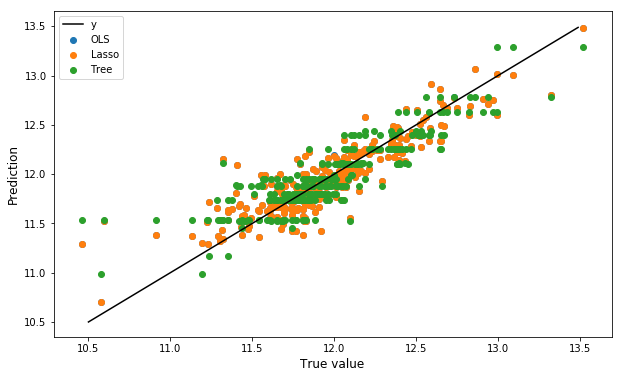

In [9]:
plot_predictions(y_test, ols_pred, lasso_pred, tree_pred)

This example is just to show you the expected output of the 3 experiments: scores on training and validation sets, coefficients or features importance. Do not focus too much on the coefficients of OLS and Lasso since we should first normalize the variables to get some insights out of it (`OverallQual` is on a 1-10 scale, `GrLivArea` is on a much bigger scale).

All that being said, we will now focus on categorical variables and ignore very powerful predictors such as `GrLivArea`.

Before moving on, notice how the predictions of the DecisionTree are all distributed in *discrete levels*, I would recommend to think about the reason for that and, then, what would happen if we use a RandomForest instead.

# Dummies and encoders

The standard approach to deal with categorical variables is to create **dummy variables**. To better understand what a dummy variable is, let's take the following data frame.

In [10]:
dum_test = df_train[['MasVnrType']].copy()
dum_test.head(10)

,MasVnrType
0,BrkFace
1,None
2,BrkFace
3,None
4,BrkFace
5,None
6,Stone
7,Stone
8,None
9,None


Here we display only the first 10 lines but it is not hard to see what this dataframe contains

In [11]:
dum_test.MasVnrType.value_counts(dropna=False)

None       863
BrkFace    443
Stone      126
BrkCmn      15
Name: MasVnrType, dtype: int64

We can use a pandas function called `get_dummies()` to, as the function says, get our dummies

In [12]:
dum_transf = pd.get_dummies(dum_test)
dum_transf.head()

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,1,0,0


In [13]:
for col in dum_transf.columns:
    print(col)
    print(dum_transf[col].value_counts())
    print('\n')

MasVnrType_BrkCmn
0    1432
1      15
Name: MasVnrType_BrkCmn, dtype: int64


MasVnrType_BrkFace
0    1004
1     443
Name: MasVnrType_BrkFace, dtype: int64


MasVnrType_None
1    863
0    584
Name: MasVnrType_None, dtype: int64


MasVnrType_Stone
0    1321
1     126
Name: MasVnrType_Stone, dtype: int64




In other words, we take all the unique values of the column, we create a new column for each one of them and set the entry to 1 or 0 depending on the values of each observation. This is confirmed by the count of `1`'s in each column that corresponds to the original one.

Another way of obtaining the same result is to use the sklearn method `OneHotEncoder`

In [14]:
encoder = OneHotEncoder()
dum_transf = encoder.fit_transform(dum_test)
pd.DataFrame(dum_transf.todense(), columns=encoder.get_feature_names()).head(10)

,x0_BrkCmn,x0_BrkFace,x0_None,x0_Stone
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0
5,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0


With 2 more lines of code (we have to fit the encoder, use it transform the data, convert the sparse matrix it returns into a matrix, making a data frame out of it) we get to the same result. I personally prefer the first approach, but OneHotEncoder can be used inside a Pipeline very easily and it can be very handy in some situations. 

For example, your model has to first impute the missing values, then create the dummies, then fit and predict. You are not even sure what kind of dummies are going to be there before the imputation. OneHotEncoder solves the problem and saves you a headache.

## OLS experiment, multicollinearity

Let's assume we want to predict the Sale Price only with from `MasVnrType`, `Alley`, and `LotShape`. Then we have to prepare the data as

In [15]:
exp_train = X_train[['MasVnrType', 'Alley', 'LotShape']].copy()
exp_test = X_test[['MasVnrType', 'Alley', 'LotShape']].copy()

exp_train = pd.get_dummies(exp_train)
exp_test = pd.get_dummies(exp_test)

exp_train.head()

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Alley_Grvl,Alley_NoAlley,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg
480,0,1,0,0,0,1,0,1,0,0,0
1445,0,0,1,0,0,1,0,0,0,0,1
382,0,0,1,0,0,1,0,1,0,0,0
1100,0,0,1,0,0,1,0,0,0,0,1
1136,0,0,1,0,0,1,0,0,0,0,1


In [16]:
res_ols, res_ols_i = OLS_experiment(exp_train, y_train, exp_test, y_test)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     45.47
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           1.09e-63
Time:                        22:57:18   Log-Likelihood:                -398.34
No. Observations:                1157   AIC:                             814.7
Df Residuals:                    1148   BIC:                             860.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
MasVnrType_BrkCmn   7.028e+11   1.01

We can see that the validation result is not that bad but the model is clearly doing something weird: all the dummies are getting the same coefficient. Moreover, their standard deviation is way too high to trust that coefficient. This means that **a small change in the data could lead to a big change of the coefficients**.

How can we interpret that?

The model is not able to distinguish the effect of the individual dummies, an effect of what is called [**multicollinearity**](https://en.wikipedia.org/wiki/Multicollinearity). This happens when two or more variables are linearly related and, in this case, it is happening among every group of dummies.

### Avoiding multicollinearity

To avoid that, we can simply drop one of the dummies. The same effect can be obtained by not fitting the intercept as well. However, this would mean changing the function for the experiment (and we have no time for that) and also not seeing that pandas provide a very easy way to drop one dummy.

In [17]:
exp_train = X_train[['MasVnrType', 'Alley', 'LotShape']].copy()
exp_test = X_test[['MasVnrType', 'Alley', 'LotShape']].copy()

exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)

exp_train.head()

,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Alley_NoAlley,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg
480,1,0,0,1,0,0,0,0
1445,0,1,0,1,0,0,0,1
382,0,1,0,1,0,0,0,0
1100,0,1,0,1,0,0,0,1
1136,0,1,0,1,0,0,0,1


In [18]:
res_ols_o, res_ols_i = OLS_experiment(exp_train, y_train, exp_test, y_test)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     56.67
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           7.90e-78
Time:                        22:57:18   Log-Likelihood:                -365.04
No. Observations:                1157   AIC:                             748.1
Df Residuals:                    1148   BIC:                             793.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
MasVnrType_BrkFace     0.3829      0

Now we are able to see the effects of each variable and any evaluation of the model improved (R-squared, AIC, BIC, etc). The scores, both in sample and out of sample, did not improve that much but we are talking about very simple models, we can't expect too much out of them.

## Lasso experiment, regularization

Lasso is a method that uses variable selection and regularization. This makes the previous issue with multicollinearity more under control as we can see from the next 2 experiments.

In [19]:
exp_train = X_train[['MasVnrType', 'Alley', 'LotShape']].copy()
exp_test = X_test[['MasVnrType', 'Alley', 'LotShape']].copy()

exp_train = pd.get_dummies(exp_train)
exp_test = pd.get_dummies(exp_test)

res_lasso = lasso_experiment(exp_train, y_train, exp_test, y_test, kfolds)

print('\n')
print('_'*40)
print('Now, let\'s drop one dummy')
print('\n')

exp_train = X_train[['MasVnrType', 'Alley', 'LotShape']].copy()
exp_test = X_test[['MasVnrType', 'Alley', 'LotShape']].copy()

exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)

res_lasso = lasso_experiment(exp_train, y_train, exp_test, y_test, kfolds)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
________________________________________
0.33400733010139644
________________________________________
                  feat     score
3     MasVnrType_Stone  0.339704
9         LotShape_IR3  0.277655
8         LotShape_IR2  0.221499
1   MasVnrType_BrkFace  0.092237
6           Alley_Pave  0.074727
5        Alley_NoAlley -0.000000
7         LotShape_IR1 -0.000000
2      MasVnrType_None -0.153377
10        LotShape_Reg -0.174480
4           Alley_Grvl -0.223098
0    MasVnrType_BrkCmn -0.279572
Validation score: 	 0.13879188101720352


________________________________________
Now, let's drop one dummy


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
___

We see that dropping one dummy changes the coefficients and, marginally, the performance, but the effect is not as drastic as before. The feature selection and the regularization were already taking care of part of the problem (notice how `LotShape_IR1` had already a very small coefficient).

## Tree experiment

Aboud DecisionTrees and more complicated models (RandomForest, XGBoost) I wrote more extensively in this other kernel: [Fantastic Trees and How to tune them](https://www.kaggle.com/lucabasa/fantastic-trees-and-how-to-tune-them). In this kernel, we are definitely not going for performance and, as you can see from the functions above, we don't try too hard to make our tree perform well.

In [20]:
exp_train = X_train[['MasVnrType', 'Alley', 'LotShape']].copy()
exp_test = X_test[['MasVnrType', 'Alley', 'LotShape']].copy()

exp_train = pd.get_dummies(exp_train)
exp_test = pd.get_dummies(exp_test)

res_tree = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

print('\n')
print('_'*40)
print('Now, let\'s drop one dummy')
print('\n')

exp_train = X_train[['MasVnrType', 'Alley', 'LotShape']].copy()
exp_test = X_test[['MasVnrType', 'Alley', 'LotShape']].copy()

exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)

res_tree = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
________________________________________
0.3351024277337352
________________________________________
                  feat     score
2      MasVnrType_None  0.516690
10        LotShape_Reg  0.210111
3     MasVnrType_Stone  0.121652
4           Alley_Grvl  0.046161
1   MasVnrType_BrkFace  0.032684
8         LotShape_IR2  0.025686
7         LotShape_IR1  0.024243
6           Alley_Pave  0.012690
5        Alley_NoAlley  0.007727
9         LotShape_IR3  0.002354
0    MasVnrType_BrkCmn  0.000000
Validation score: 	 0.13972665599342327


________________________________________
Now, let's drop one dummy


DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           

As in the previous case, our tree is not showing improvements if we drop a dummy.

We can finally see how the predictions of the 3 experiments on the validation set are.

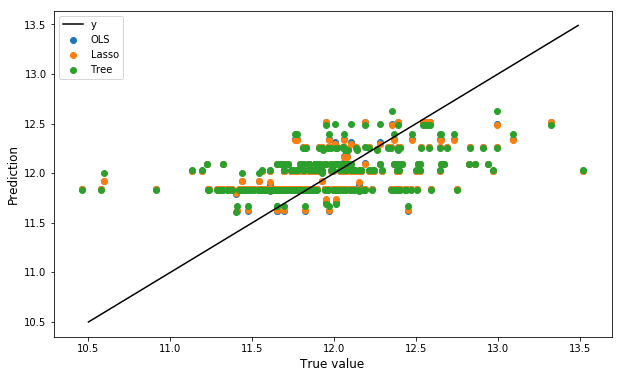

In [21]:
plot_predictions(y_test, res_ols_o, res_lasso, res_tree)

As we see, the 3 models are very much in agreement on getting the predictions wrong and, since we are using only discrete values while before there were continuous features, the predictions tend to be on more definite *levels*.

## The wrong way of handling dummies

Sometimes it is tempting to simply encode the unique values into numerical one. One way to do so is to use sklearn's method `LabelEncoder` and we see how it works in the following cell (I keep the original column for clarity)

In [22]:
le = LabelEncoder()
dum_test['encoded'] = le.fit_transform(dum_test.MasVnrType)
dum_test.head(10)

,MasVnrType,encoded
0,BrkFace,1
1,None,2
2,BrkFace,1
3,None,2
4,BrkFace,1
5,None,2
6,Stone,3
7,Stone,3
8,None,2
9,None,2


The error here is that our encoding **forced an order among the categories**. It is saying to our models that `BrkFace < None < Stone` and this can be very harmful to both the performance and the explainability of the model because that ordering does not make any sense. 

In [23]:
exp_train = X_train[['MasVnrType', 'Alley', 'LotShape']].copy()
exp_test = X_test[['MasVnrType', 'Alley', 'LotShape']].copy()

exp_train = exp_train.apply(le.fit_transform)
exp_test = exp_test.apply(le.fit_transform)

exp_train.head()

,MasVnrType,Alley,LotShape
480,1,1,0
1445,2,1,3
382,2,1,0
1100,2,1,3
1136,2,1,3


In [24]:
tmp,tmp_1 = OLS_experiment(exp_train, y_train, exp_test, y_test)

print('\n')

tmp = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     39.38
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           3.15e-24
Time:                        22:57:20   Log-Likelihood:                -501.14
No. Observations:                1157   AIC:                             1010.
Df Residuals:                    1153   BIC:                             1031.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MasVnrType     0.0016      0.018      0.091      0.9

Which is significantly worse for OLS (and Lasso, not displayed) and puts us in trouble if we have to explain the model to someone else. 

The result for the DecisionTree is not worse. To understand why, let's visualize the decisions of our tree if only had one variable, like the following

In [25]:
exp_train = X_train[['MasVnrType']].copy()
exp_train = pd.get_dummies(exp_train)
exp_train.head()

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
480,0,1,0,0
1445,0,0,1,0
382,0,0,1,0
1100,0,0,1,0
1136,0,0,1,0


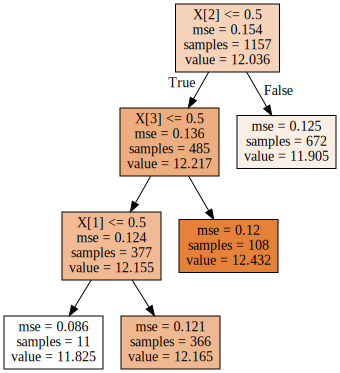

In [26]:
from sklearn import tree
import graphviz

dt = DecisionTreeRegressor().fit(exp_train, y_train)

dot_data = tree.export_graphviz(dt, out_file=None, filled=True)  
graph = graphviz.Source(dot_data)  
graph

As we see, the tree does a first split on `MasVnrType_None`, then on `MasVnrType_Stone`, and finally on `MasVnrType_BrkFace`.

Now, if we use the label encoder instead, we get

In [27]:
exp_train = X_train[['MasVnrType']].copy()
exp_train['MasVnrType'] = le.fit_transform(exp_train.MasVnrType)
exp_train.head()

,MasVnrType
480,1
1445,2
382,2
1100,2
1136,2


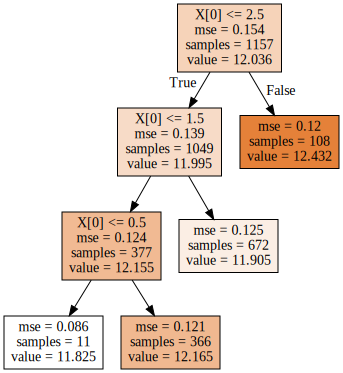

In [28]:
dt = DecisionTreeRegressor().fit(exp_train, y_train)

dot_data = tree.export_graphviz(dt, out_file=None, filled=True)  
graph = graphviz.Source(dot_data)  
graph

Now there is only one variable and it is splitting the same amount of times but, if we check what are the values it is splitting on, we notice it is doing the same splits and thus getting the same results.

All that being said, introducing an ordering when it was not there, at the very least, makes your model less explainable and this is mostly an issue when you have to start correcting something about it (or you have to explain it to a colleague, or a client).

# Ordinal variables and measurement errors

There are situations where the categories suggest an order. For example, let's have a look at `ExterQual`

In [29]:
df_train.ExterQual.value_counts()

TA    905
Gd    479
Ex     49
Fa     14
Name: ExterQual, dtype: int64

Here, it is easy to argue that `Ex > Gd > TA > Fa` because *Excellent* is better than *Good* and so on. Now using the LabelEncoder would give us

In [30]:
ord_test = df_train[['ExterQual']].copy()
ord_test['encoded'] = le.fit_transform(ord_test.ExterQual)
ord_test.head()

,ExterQual,encoded
0,Gd,2
1,TA,3
2,Gd,2
3,TA,3
4,Gd,2


In [31]:
pd.crosstab(ord_test.encoded, ord_test.ExterQual)

ExterQual,Ex,Fa,Gd,TA
encoded,,,,
0,49,0,0,0
1,0,14,0,0
2,0,0,479,0
3,0,0,0,905


Again, not quite what we want. There is an order, but not a reasonable one. The encoder is assigning an alphabetical order. 

Let's see a couple more approaches to get what we want. First, a quick summary of what are we dealing with.

In [ ]:
ord_test = df_train[['ExterQual', 'target']].copy()
ord_test.groupby('ExterQual').agg(['mean', 'median', 'max', 'min', 'count'])

To give a simple ordering to these categories, we can do the following

In [ ]:
ord_test.loc[ord_test.ExterQual == 'Fa', 'ExtQuGroup'] = 0
ord_test.loc[ord_test.ExterQual == 'TA', 'ExtQuGroup'] = 1
ord_test.loc[ord_test.ExterQual == 'Gd', 'ExtQuGroup'] = 2
ord_test.loc[ord_test.ExterQual == 'Ex', 'ExtQuGroup'] = 3

ord_test['LabelEncoded'] = le.fit_transform(ord_test.ExterQual)

x1 = ord_test['ExtQuGroup']
x2 = ord_test['LabelEncoded']
y = ord_test['target']

print('Correlations with target')
print(ord_test[['ExtQuGroup','LabelEncoded' ,'target' ]].corr())

fig, ax= plt.subplots(1,2, figsize=(15, 6))

sns.regplot(x = x1, y = y, x_estimator = np.mean, ax=ax[0])
sns.regplot(x = x2, y = y, x_estimator = np.mean, ax=ax[1])

ax[0].set_title('Manual encoding', fontsize=16)
ax[1].set_title('Automatic encoding', fontsize=16)

We see that the automatic encoding makes much less sense (the order would not be a problem, of course). All that being said, the weird encoding is only for the `FA` category, which is present only 14 times.

As a further example, let's take 

In [ ]:
ord_test = df_train[['HeatingQC', 'target']].copy()

ord_test.loc[ord_test.HeatingQC == 'Po', 'HeatQGroup'] = 1
ord_test.loc[ord_test.HeatingQC == 'Fa', 'HeatQGroup'] = 2
ord_test.loc[ord_test.HeatingQC == 'TA', 'HeatQGroup'] = 3
ord_test.loc[ord_test.HeatingQC == 'Gd', 'HeatQGroup'] = 4
ord_test.loc[ord_test.HeatingQC == 'Ex', 'HeatQGroup'] = 5

ord_test['LabelEncoded'] = le.fit_transform(ord_test.HeatingQC)

x1 = ord_test['HeatQGroup']
x2 = ord_test['LabelEncoded']
y = ord_test['target']

print('Correlations with target')
print(ord_test[['HeatQGroup','LabelEncoded' ,'target' ]].corr())

fig, ax= plt.subplots(1,2, figsize=(15, 6))

sns.regplot(x = x1, y = y, x_estimator = np.mean, ax=ax[0])
sns.regplot(x = x2, y = y, x_estimator = np.mean, ax=ax[1])

ax[0].set_title('Manual encoding', fontsize=16)
ax[1].set_title('Automatic encoding', fontsize=16)

Not only here we see a significant difference between the manual and the automatic encoding (again strongly in favor of the manual one), but we can also notice that it is possible that our encoding is not the optimal one. Although it is often a bad idea to tweak too much the processing of the data and enforce patterns that we believe are important, one may argue that **there is no objective scale that says that Good is 1 point better than Typical and 1 point worse than Excellent**, we are enforcing that pattern as well.

In this particular case, we don't even know if the data were gathered by the same people, that have the same parameters to judge the quality of the heating. In fact, we can easily find a better numerical encoding.

In [ ]:
ord_test = df_train[['HeatingQC', 'target']].copy()

ord_test.loc[ord_test.HeatingQC == 'Po', 'HeatQGroup'] = 1
ord_test.loc[ord_test.HeatingQC == 'Fa', 'HeatQGroup'] = 2
ord_test.loc[ord_test.HeatingQC == 'TA', 'HeatQGroup'] = 3
ord_test.loc[ord_test.HeatingQC == 'Gd', 'HeatQGroup'] = 4
ord_test.loc[ord_test.HeatingQC == 'Ex', 'HeatQGroup'] = 5

ord_test.loc[ord_test.HeatingQC == 'Po', 'HeatQGroup_2'] = 1
ord_test.loc[ord_test.HeatingQC == 'Fa', 'HeatQGroup_2'] = 1
ord_test.loc[ord_test.HeatingQC == 'TA', 'HeatQGroup_2'] = 3
ord_test.loc[ord_test.HeatingQC == 'Gd', 'HeatQGroup_2'] = 4
ord_test.loc[ord_test.HeatingQC == 'Ex', 'HeatQGroup_2'] = 7

x1 = ord_test['HeatQGroup']
x2 = ord_test['HeatQGroup_2']
y = ord_test['target']

print('Correlations with target')
print(ord_test[['HeatQGroup','HeatQGroup_2' ,'target' ]].corr())

fig, ax= plt.subplots(1,2, figsize=(15, 6))

sns.regplot(x = x1, y = y, x_estimator = np.mean, ax=ax[0])
sns.regplot(x = x2, y = y, x_estimator = np.mean, ax=ax[1])

ax[0].set_title('Old encoding', fontsize=16)
ax[1].set_title('New encoding', fontsize=16)

Now, which one is better? 

In principle, both and neither. Since there is no real rule, we are allowed to make assumptions and go along with them. Indeed, one may even argue that, since the ordering is clear but the magnitude is not, we can again use dummies and let the model decide what is the relation with the target.

This paves the way to the next set of experiments. This time we will use only a few ordinal variables and see if the models *learn* differently if we use a different encoding.

In [ ]:
print('With a normal encoding')
print('\n')

exp_train = X_train[['HeatingQC']].copy() # , 'ExterQual', 'KitchenQual'
exp_test = X_test[['HeatingQC']].copy()

norm_encode = {'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex': 5}

exp_train['HeatingQC'] = exp_train.HeatingQC.map(norm_encode).astype(int)
exp_test['HeatingQC'] = exp_test.HeatingQC.map(norm_encode).astype(int)
#exp_train['ExterQual'] = exp_train.ExterQual.map(norm_encode).astype(int)
#exp_test['ExterQual'] = exp_test.ExterQual.map(norm_encode).astype(int)
#exp_train['KitchenQual'] = exp_train.KitchenQual.map(norm_encode).astype(int)
#exp_test['KitchenQual'] = exp_test.KitchenQual.map(norm_encode).astype(int)

lasso_pred_norm = lasso_experiment(exp_train, y_train, exp_test, y_test, kfolds)

print('_'*40)

print('\n Now by encoding HeatingQC differently')
print('\n')

exp_train = X_train[['HeatingQC']].copy()
exp_test = X_test[['HeatingQC']].copy()

norm_encode = {'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex': 5}
new_encode = {'Po': 1, 'Fa': 1, 'TA':3, 'Gd':4, 'Ex': 7}

exp_train['HeatingQC'] = exp_train.HeatingQC.map(new_encode).astype(int)
exp_test['HeatingQC'] = exp_test.HeatingQC.map(new_encode).astype(int)
#exp_train['ExterQual'] = exp_train.ExterQual.map(norm_encode).astype(int)
#exp_test['ExterQual'] = exp_test.ExterQual.map(norm_encode).astype(int)
#exp_train['KitchenQual'] = exp_train.KitchenQual.map(norm_encode).astype(int)
#exp_test['KitchenQual'] = exp_test.KitchenQual.map(norm_encode).astype(int)

lasso_pred_new = lasso_experiment(exp_train, y_train, exp_test, y_test, kfolds)

print('_'*40)

print('\n Now by getting dummies')
print('\n')

exp_train = X_train[['HeatingQC']].copy()
exp_test = X_test[['HeatingQC']].copy()

# dirty fix for dummies mismatch
exp_test.loc[exp_test.HeatingQC == 'Po', 'HeatingQC'] = 'Fa' 

exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)

lasso_pred_dum = lasso_experiment(exp_train, y_train, exp_test, y_test, kfolds)

We see that using dummies is better than giving a *standard* ordering but they are both worse than our *enhanced* one.

In summary, the lesson here is that we can't give an ordering to something that is not supposed to have one (as in the previous section) but, when we do, we should keep in mind that **we are making an assumption** when we put numerical values in our data. As such, we should keep track of our choices and how the model is reacting to that.

All that being said, trees are indeed an amazing thing and, for reasons that should be clear by now given our previous experiment, they really don't care much about what number we put in as far the order stays the same (and yes, they perform poorly all the times but, hey, consistency is a virtue). 

In [ ]:
print('With a normal encoding')
print('\n')

exp_train = X_train[['HeatingQC']].copy() # , 'ExterQual', 'KitchenQual'
exp_test = X_test[['HeatingQC']].copy()

norm_encode = {'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex': 5}

exp_train['HeatingQC'] = exp_train.HeatingQC.map(norm_encode).astype(int)
exp_test['HeatingQC'] = exp_test.HeatingQC.map(norm_encode).astype(int)
#exp_train['ExterQual'] = exp_train.ExterQual.map(norm_encode).astype(int)
#exp_test['ExterQual'] = exp_test.ExterQual.map(norm_encode).astype(int)
#exp_train['KitchenQual'] = exp_train.KitchenQual.map(norm_encode).astype(int)
#exp_test['KitchenQual'] = exp_test.KitchenQual.map(norm_encode).astype(int)

tree_pred_norm = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

print('_'*40)

print('\n Now by encoding HeatingQC differently')
print('\n')

exp_train = X_train[['HeatingQC']].copy()
exp_test = X_test[['HeatingQC']].copy()

norm_encode = {'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex': 5}
new_encode = {'Po': 1, 'Fa': 1, 'TA':3, 'Gd':4, 'Ex': 7}

exp_train['HeatingQC'] = exp_train.HeatingQC.map(new_encode).astype(int)
exp_test['HeatingQC'] = exp_test.HeatingQC.map(new_encode).astype(int)
#exp_train['ExterQual'] = exp_train.ExterQual.map(norm_encode).astype(int)
#exp_test['ExterQual'] = exp_test.ExterQual.map(norm_encode).astype(int)
#exp_train['KitchenQual'] = exp_train.KitchenQual.map(norm_encode).astype(int)
#exp_test['KitchenQual'] = exp_test.KitchenQual.map(norm_encode).astype(int)

tree_pred_new = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

print('_'*40)

print('\n Now by getting dummies')
print('\n')

exp_train = X_train[['HeatingQC']].copy()
exp_test = X_test[['HeatingQC']].copy()

# dirty fix for dummies mismatch
exp_test.loc[exp_test.HeatingQC == 'Po', 'HeatingQC'] = 'Fa' 

exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)

tree_pred_dum = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

# Not all the dummies show up every time

As the most curious of you noticed from my hidden code, I made a small hack in the previous cells when I made dummies out of my variable. Indeed, we can see that there is a **mismatch between training and validation set**.

In [ ]:
print('Training set')
exp_train = X_train[['HeatingQC']].copy()
exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_train.head()

In [ ]:
print('Validation set')
exp_test= X_test[['HeatingQC']].copy()
exp_test = pd.get_dummies(exp_test, drop_first=True)
exp_test.head()

We see that the value `Po` is missing in the training set (`Ex` has been dropped in both sets by get_dummies). If we try to run a model now, we will get an error because the columns are different. 

The dirty fix I adopted before is to simply **recode `Po` to `Fa`** before creating the dummies so that the mismatch is not there. This can be justifiable if we look at the counts of each category.

In [ ]:
df_train.HeatingQC.value_counts()

It is indeed an annoying little observation and changing it should not compromise our model (to be fair, we should ask ourselves serious questions about the model if it does). 

Another approach can be to **first create the dummies and then split into training and validation set**. In this case, we get

In [ ]:
mis_dum = df_train[['HeatingQC']].copy()
mis_dum = pd.get_dummies(mis_dum)

mis_d_train, mis_d_test, mis_d_y_train,  mis_d_y_test = train_test_split(mis_dum, df_train.target, test_size=0.20, random_state=42)

print(mis_d_train.columns)
print(f'Number of `Po`: \t {mis_d_train.HeatingQC_Po.sum()}')
print('\n')
print(mis_d_test.columns)
print(f'Number of `Po`: \t {mis_d_test.HeatingQC_Po.sum()}')

The result is simply an extra column of 0's into the training set.

Another option would be to only keep the common columns and train with them. This can be annoying if the number of mismatched dummies grows, but we can write a couple of lines of code for that

In [ ]:
dum_col = ['HeatingQC', 'GarageQual', 'Condition2', 'Utilities', 'Heating']

exp_train = X_train[dum_col].copy()
exp_test = X_test[dum_col].copy()
exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)

print('Mismatched dummies:')
print(list(set(exp_train.columns) - set(exp_test.columns)))

exp_train = exp_train[[col for col in exp_test.columns if col in exp_train.columns]]
exp_test = exp_test[[col for col in exp_train.columns]]  # yes, it has to be done twice

print('\nCommon columns: ')
print(list(exp_train.columns))

And we thus are ready to train and validate our model. 

Naturally, there is always the *butchery* approach which is **ignore the observations with specific values** (can be tricky with many features to dummify) or **do not train the model with the features that give you this problem** (which would reduce the complexity of the model, not necessarily a bad thing).

As usual, understanding why the mismatch is happening is crucial to the decision to take about it. My default approach is to not use features that I don't understand but this can sometimes mean accept a drop in accuracy of the model at the advantage of its explainability.

In the previous examples, the reason for the mismatch was very clear and helps us introduce the next topic

## Features with very rare categories

In this section, we will focus on those features that have very rare categories and test how our models struggle if we ask them to learn on those categories. Furthermore, we will see if the same behavior can be observed for both categorical and ordinal features.

To do so, we will focus on the following features

In [ ]:
rare_cat = ['MSZoning', 'LotShape', 'Foundation', 'MasVnrType']
rare_ord = ['GarageQual', 'ExterQual']

For example, thisi is how `Foundation` looks like

In [ ]:
df_train.Foundation.value_counts()

As we see, `Slab`, `Stone`, and `Wood` are very unfrequent. Let's see if we spot a difference in performance or not. We already have a problem because `Wood` appears only in the train set, but we just drop the column for now.

In [ ]:
exp_train = X_train[rare_cat].copy()
exp_test = X_test[rare_cat].copy()

exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)

del exp_train['Foundation_Wood']

print('Lasso experiment')
lasso_pred = lasso_experiment(exp_train, y_train, exp_test, y_test, kfolds)
print('\n')
print('Tree experiment')
tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

## Put the rare categories together by using the documentation

This approach aims to create less unfrequent categories by putting together 2 or more categories with the suggestion of the documentation. For example, in `LotShape` we could group all the `IR#` categories into a generic `irregular`one.

In [ ]:
exp_train = X_train[rare_cat].copy()
exp_test = X_test[rare_cat].copy()

# floating villages can be low density residential area
exp_train.loc[exp_train.MSZoning == 'FV', 'MSZoning'] = 'RL'  
exp_test.loc[exp_test.MSZoning == 'FV', 'MSZoning'] = 'RL'
# medium and high density residential areas can be considered, with commercial area, a non low density residential area
exp_train.loc[exp_train.MSZoning != 'RL', 'MSZoning'] = 'notRL'  
exp_test.loc[exp_test.MSZoning != 'RL', 'MSZoning'] = 'notRL'

# LotShape is either regular or irregular
exp_train.loc[exp_train.LotShape != 'Reg', 'LotShape'] = 'IRR'
exp_test.loc[exp_test.LotShape != 'Reg', 'LotShape'] = 'IRR'

# making foundations simpler
fond = ['PConc', 'CBlock']
exp_train.loc[~exp_train.Foundation.isin(fond), 'Foundation'] = 'Other'
exp_test.loc[~exp_test.Foundation.isin(fond), 'Foundation'] = 'Other'

# MasVnrType doesn't need 2 types of bricks
exp_train.loc[exp_train.MasVnrType == 'BrkCmn', 'MasVnrType'] = 'BrkFace'
exp_test.loc[exp_test.MasVnrType == 'BrkCmn', 'MasVnrType'] = 'BrkFace'

exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)

tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

Since we train on fewer features, we observe a better fit (only for the tree) and a lower score on the validation set and one may argue that this experiment didn't go so well. Again, this gives us the opportunity to think about how the tree algorithm is acting. Having a smaller set of features to choose from, it can finish faster and learn the data better. As an exercise, one could try a different kind of grouping of the above features to see how this changes the result.

## Let a model help you

Looking at the first experiment of this section, we notice that, for example, `MSZoning_FV` and `MSZoning_RL` are getting similar coefficients. Since they also represent similar categories, we can use this information and group them up to reduce the sparsity of our categories. The other values do not look playing a similar role, so we let them separated. We expect to see the Lasso experiment producing slightly better results. 

I would not get too greedy with this strategy because it is important to keep in mind the meaning of each feature (thus do I would not group categories only because they have a similar coefficient). To test why it can get too greedy, try to uncomment the lines in the following code and see how the result is changing

In [ ]:
exp_train = X_train[rare_cat].copy()
exp_test = X_test[rare_cat].copy()

# floating villages can be low density residential area
exp_train.loc[exp_train.MSZoning == 'FV', 'MSZoning'] = 'RL'  
exp_test.loc[exp_test.MSZoning == 'FV', 'MSZoning'] = 'RL'

# Smoothing out the levels or irregularity
exp_train.loc[exp_train.LotShape == 'IR2', 'LotShape'] = 'IR3'
exp_test.loc[exp_test.LotShape == 'IR2', 'LotShape'] = 'IR3'

# making foundations simpler
#exp_train.loc[exp_train.Foundation == 'Stone', 'Foundation'] = 'PConc' # Similar coefficients, but not similar categories
#exp_test.loc[exp_test.Foundation == 'Stone', 'Foundation'] = 'PConc'
#exp_train.loc[exp_train.Foundation == 'Wood', 'Foundation'] = 'PConc'


exp_train = pd.get_dummies(exp_train, drop_first=True)
exp_test = pd.get_dummies(exp_test, drop_first=True)
del exp_train['Foundation_Wood']

print('Lasso experiment')
lasso_pred = lasso_experiment(exp_train, y_train, exp_test, y_test, kfolds)
print('\n')
print('Tree experiment')
tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

## Rare ordinal features

This is way much less of an issue if you have already converted it to numeric values (with any strategy) because this will not throw you an error. For example, `GarageQual` has very rarely the value `Ex` or `Po` but, as we see in the next two cells, correcting for this sparsity has little to no effect.

In [ ]:
exp_train = X_train[['GarageQual']].copy()
exp_test = X_test[['GarageQual']].copy()

to_num = {'NoGrg': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

exp_train['GarageQual'] = exp_train['GarageQual'].map(to_num).astype(int)
exp_test['GarageQual'] = exp_test['GarageQual'].map(to_num).astype(int)

print('Tree experiment')
tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

While, if we correct for the mentioned sparsity, we get

In [ ]:
exp_train = X_train[['GarageQual']].copy()
exp_test = X_test[['GarageQual']].copy()

to_num = {'NoGrg': 0, 'Po': 2, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 4}

exp_train['GarageQual'] = exp_train['GarageQual'].map(to_num).astype(int)
exp_test['GarageQual'] = exp_test['GarageQual'].map(to_num).astype(int)

print('Tree experiment')
tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

# From continuous to categorical

There are situations where it is tempting to take a continuous variable and make bins out it (thus making it a categorical one). While in general this can lead to a model that fits the data less than before (due to the fact that you are being somewhat less accurate with your predictors), there are situations where you can have some success with it. A non-comprehensive list of these situations is

* you don't trust entirely the accuracy of the measurements that led to those data. For example, you have a column containing many distances from a reference point and you are not sure if those distances were measured accurately, you might just group all the distances below 1 Km to a category, then another category with 1-2 Km, etc. In this way, **you are assuming there is no difference inside of the same bin** and, if the measure is really inaccurate as you think, you are removing some noise to make better predictions.
* you don't think that a variable is influencing in a continuous way your response, then you can force your model to see the data in *steps* 
* A variable is continuous but it takes almost exclusively one specific value. The classic example is a feature that is 0 almost always and then it takes very rare positive values (even really high one). In this case, you can get a clearer signal by simply binarizing this variable (thus transforming every positive value into a 1).

As before, only knowledge, context, and performance will tell you what is a good idea and what isn't. Let's make some experiment. 

A good example is provided by the features `GarageArea` and `GarageCars`. If we plot them both against our target, we see how `GarageCars` could be interpreted as the categorical version of `GarageArea` (which makes a lot of sense, since bigger garages can contain more cars).

In [ ]:
g = sns.FacetGrid(df_train, hue="GarageCars", height=8)
g.map(plt.scatter, "GarageArea", "target", edgecolor="w")
g.add_legend()

If we use `GarageArea` (thus a continuous variable), we get

In [ ]:
exp_train = X_train[['GarageArea']].copy()
exp_test = X_test[['GarageArea']].copy()

print('OLS experiment')  # lasso would give the same
ols_pred, ols_i_pred = OLS_experiment(exp_train, y_train, exp_test, y_test)
print('\n')
print('Tree experiment')
tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

plot_predictions(y_test, ols_pred, ols_pred, tree_pred)  

While, by using the categorical (orginal) variable `GarageCars`

In [ ]:
exp_train = X_train[['GarageCars']].copy()
exp_test = X_test[['GarageCars']].copy()

print('OLS experiment')
ols_pred, ols_i_pred = OLS_experiment(exp_train, y_train, exp_test, y_test)
print('\n')
print('Tree experiment')
tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

plot_predictions(y_test, ols_pred, ols_pred, tree_pred)

In this case, we see that the simple models are learning the signal a bit better when we use `GarageCars`. One could argue that, despite the better performance according to our metric, a model that predicts only 4 values is better than the previous one but we are not here to win this competition. This would spark a conversation about evaluating your model with an appropriate metric (not necessarily the one Kaggle suggests), but this is not a kernel for high scoring models.

There is some difference in the predictions and this is most likely due to some non-linear effect that is difficult for the OLS and Lasso regressors. 

Just out of curiosity this is what happens if we make dummies out of `GarageCars`. This means removing the ordering between the values but helping the models to learn potentially non-linear relationships.

In [ ]:
exp_train = X_train[['GarageCars']].copy()
exp_test = X_test[['GarageCars']].copy()

exp_train['GarageCars'] = exp_train['GarageCars'].astype(str)
exp_test['GarageCars'] = exp_test['GarageCars'].astype(str)

exp_train = pd.get_dummies(exp_train)
exp_test = pd.get_dummies(exp_test)

del exp_train['GarageCars_4']

print('OLS experiment')
ols_pred, ols_i_pred = OLS_experiment(exp_train, y_train, exp_test, y_test)
print('\n')
print('Tree experiment')
tree_pred = tree_experiment(exp_train, y_train, exp_test, y_test, kfolds)

plot_predictions(y_test, ols_pred, ols_pred, tree_pred)

And we finally have all models learning the same relation and producing the same poor prediction. From the OLS experiment we see also that, even though we removed the ordering between the various values, the model still thinks that with a bigger garage the house costs more.

# Features with a large number of categories

Sometimes it can happen that a categorical feature presents way too many individual values to be made a one-hot-encoded (no matter the technique). For example, let's have a look at the feature `Neighborhood`.

In [ ]:
df_train.Neighborhood.value_counts()

If we make dummies out of this feature we end up with 25 columns and this can make harder for any model to learn the data. The fancy name of this is **curse of dimensionality** and, from its name, we don't need much to know that we don't want it.

One approach would be to group some neighborhoods in order to reduce the number of dummies. However, this would require both knowledge of the city in order to group them appropriately (which we don't have) and quite some time to do so. If the first problem is solvable, the second can become worse and worse as the number of categories grows.

## Frequency encoding and hashing

The idea behind frequency encoding is to label each category by using its frequency of appearance in the dataset. This is useful for two reasons: 

* we convert the feature to a numerical type and this ensures that the models can run without errors
* if there is a relationship between the target and how common (or uncommon) a category is, we can learn that relationship.

As for everything else, a good understanding of the problem will drive the decision of using this particular encoding or not. In this case, for example, it is not the most useful thing in terms of scoring, but since none of us is here for the scoring it is worth spending a minute to show how to implement it.

A simple way to implement it is the following

In [ ]:
exp_train = X_train[['Neighborhood']].copy()
exp_test = X_test[['Neighborhood']].copy()
# getting the frequency in the training set only, you can also use the full set if it is available
freq_train = exp_train.groupby('Neighborhood').size() / len(exp_train) 

exp_train['Enc_Neigh'] = exp_train['Neighborhood'].map(freq_train)
exp_test['Enc_Neigh'] = exp_test['Neighborhood'].map(freq_train)

exp_train.sample(10)

Another approach to obtain a similar result is to use `rankdata` from the library `scipy.stats`, necessary in case of ties. [Here a link to the documentation](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.rankdata.html).

At last, one could try the **hashing trick**.

A hash function maps an integer to a finite integer range \[1,m\]. The input can take values larger than *m*, thus allowing us to reduce the number of categories. This also means that multiple numbers may get mapped to the same output (something that is called *collision*). Another advantage is that feature hashing compresses the original feature into a vector of dimension m and, since it can be applied even to strings, this lead to a significant saving on the memory side. 

A simple implementation to get a taste of how it works is the following.

In [ ]:
from sklearn.feature_extraction import FeatureHasher

m = int(len(set(df_train.Neighborhood)))  # number of unique neighboorhoods

h = FeatureHasher(n_features=m, input_type='string')

f = h.transform(df_train['Neighborhood'])

f

We now have a sparse matrix of the dimensions of number of rows times the number of unique Neighboorhoods, which is very close to what we obtain by using `get_dummies` and we have a loss in interpretability, given the fact that the matrix looks like this

In [ ]:
f.toarray()

But we can decide, for example, to half the number of bins to map our feature to, obtaining

In [ ]:
m = int(len(set(df_train.Neighborhood))/2)
h = FeatureHasher(n_features=m, input_type='string')
f = h.transform(df_train['Neighborhood'])
f

In [ ]:
f.toarray()

# Final tips

Understanding categorical features can give help you building a solid model, a model that you can explain to a colleague or to a client. I hope the techniques here displayed can inspire you for the next time you will explore further applications on your own.

Among the things we didn't explore here, there is how to use use a categorical feature together with another one (what we could call an interaction). For example, one can use the average size of the houses in a Neighborhood as a feature

In [ ]:
exp_train = X_train[['GrLivArea', 'Neighborhood']].copy()
exp_test = X_test[['GrLivArea', 'Neighborhood']].copy()

avg_area = exp_train.groupby('Neighborhood', as_index=False).mean()

conversion = dict(zip(avg_area.Neighborhood, avg_area.GrLivArea))

exp_train['Neigh_avg_area'] = exp_train['Neighborhood'].map(conversion)
exp_test['Neigh_avg_area'] = exp_test['Neighborhood'].map(conversion)

exp_test.sample(10)

Which is also a way of encoding Neighborhood to a numerical value (and this is why we used the same technique as in the previous section). Or you can use counts, simple multiplications, anything that your creativity and your understanding of the problem will suggest you.

A word of caution about using several observations to create a feature like in the previous case that we use all the observations from a neighborhood at the same time. If your validation strategy is not solid, this can and will lead to some information leak in your model, meaning that your training data have somehow already seen the test data. This can lead to inflated cross-validation scores and poorer generalization power for your model. 

The last point is especially dangerous if you start using the target variable in your feature engineering (sometimes called target encoding). For example, you can use the mean price of the house in a neighborhood as a feature. Such a feature makes a lot of sense because the average price of a house in an area can be well known a priori, but expose you to the situation where the model *sees* the target more than once. One way is to properly separate training, validation, and test set (as we did here) but it turns out that using a statistics that does not change its distribution with or without any data point can be considered approximatively leakage-proof. This can be achieved, for example, by adding some random noise.

## ***Please comment if something is not clear or completely wrong. Or upvote if you found this kernel useful. Or both. Or neither, really, it is great that you read this far already.***